### 图像加载与预处理

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### 加载图像

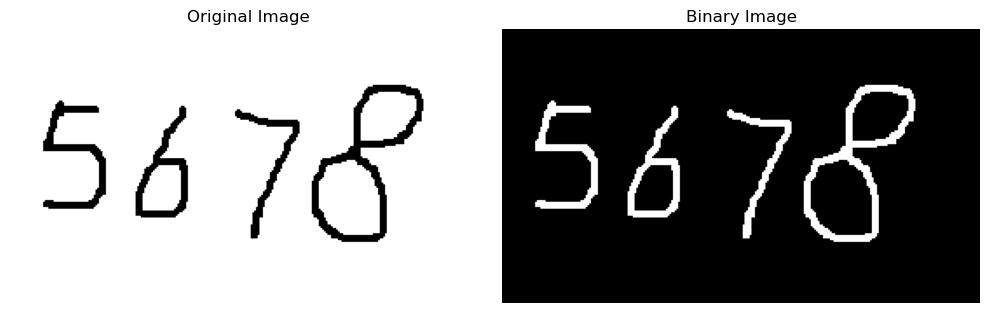

In [2]:
image = cv2.imread('./data/5678.png', cv2.IMREAD_GRAYSCALE) # cv2.IMREAD_GRAYSCALE表示加载为灰度图像

# 二值化
"""
黑色（0） 白色（255）
127是阈值
255是大于阈值时设置的像素值
cv2.THRESH_BINARY_INV是指反转二值化（黑色为前景，白色为背景）
如果用cv2.THRESH_BINARY，则会得到常规的白底黑字二值图像
"""
_, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)

plt.figure(figsize=(10, 5))
# 显示原始图像
plt.subplot(1, 2, 1)  # 1行2列，第1个子图
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# 显示二值化后的图像
plt.subplot(1, 2, 2)  # 1行2列，第2个子图
plt.imshow(binary_image, cmap='gray')
plt.title("Binary Image")
plt.axis('off')

# 展示图像
plt.tight_layout()
plt.show()


### 轮廓检测

In [3]:
"""
cv2.RETR_EXTERNAL：表示只检测外部轮廓，不考虑内部轮廓
cv2.CHAIN_APPROX_SIMPLE：使用简单的链式近似法来表示轮廓。它将多余的点压缩成直线段，只保留轮廓的端点，从而减少计算量。
"""
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# 按轮廓的中心点的 x 坐标排序
def sort_contours(contours):
    # 将轮廓转换为列表
    contours_list = list(contours)
    # 按 x 坐标排序
    contours_list.sort(key=lambda c: cv2.boundingRect(c)[0])
    return contours_list

# 对轮廓进行排序
contours = sort_contours(contours)

In [4]:
# 遍历轮廓，提取每个数字
digit_images = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour) # cv2.boundingRect(contour)：这个函数返回一个最小矩形（bounding box），它包围了每个轮廓
    if h > 20 and w > 10:  # 筛选掉过小的区域
        # digit = binary_image[y:y+h, x:x+w]
        padding = 30  # 增加边缘填充
        digit = binary_image[max(y - padding, 0):y + h + padding, max(x - padding, 0):x + w + padding]
        # digit_resized = cv2.resize(digit, (28, 28))  # 调整到模型输入大小
        digit_images.append(digit)
len(digit_images)

4

### 展示分割之后的图像

C:\Users\PC\AppData\Local\Temp\ipykernel_14912\873330583.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


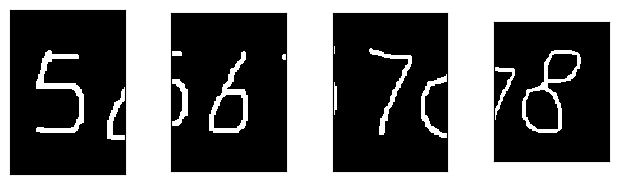

In [5]:
plt.figure()
for i in range(len(digit_images)):
    plt.subplot(1, len(digit_images), i + 1)
    plt.tight_layout()
    plt.imshow(digit_images[i], cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])
plt.show()

### 数字识别

In [6]:
import torch
from PIL import Image
import torchvision.transforms as transforms

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
class Net(torch.nn.Module):
    def __init__(self):
        # （batch,1,28,28）
        super(Net, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3), #（batch,32,26,26） 输入通道数1输出通道数32 32为小型任务的经验性选择，一般每层增加一倍欠拟合就加过拟合减
            torch.nn.BatchNorm2d(32), # 对卷积层的输出进行批量归一化，使得每个特征图的分布更加稳定，从而加速训练并提高模型性能。
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2), #（batch,32,13,13）
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3), #（batch,64,11,11）
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2), #（batch,64,5,5）
        )
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(1600, 50), # 1600 == 64*5*5
            torch.nn.ReLU(),  # 添加ReLU激活函数 增加模型的非线性能力
            torch.nn.Dropout(0.5), # 有效防止过拟合-丢弃率0.5          BN层和dropout层一起用效果不好（ 深层可能不好BN在后Dropout在前也不好
            torch.nn.Linear(50, 10)
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv1(x)  # 一层卷积层,一层池化层,一层激活层
        x = self.conv2(x)  # 再来一次
        x = x.view(batch_size, -1)  # flatten 变成全连接网络需要的输入
        x = self.fc(x)
        return x  # 最后输出的是维度为10的，也就是（对应数学符号的0~9）

In [9]:
model = Net().to(device)

model_path = '../models/1_Handwritten_Digit_Recognition/model_weights.pth'

# 加载模型参数
model.load_state_dict(torch.load(model_path))

# 将模型设置为评估模式
model.eval()

C:\Users\PC\AppData\Local\Temp\ipykernel_14912\457276358.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Net(
  (conv1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=1600, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [10]:
# 预测函数
def predict_image(image, model):
    # image = Image.open(image_path)
    image = Image.fromarray(image)
    # 图像预处理
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # 转换为灰度
        transforms.Resize((28, 28)),                 # 调整到 28x28
        transforms.ToTensor(),                       # 转换为张量
        transforms.Normalize((0.1307,), (0.3081,))         # 归一化到 [-1, 1]
    ])
    image = transform(image)
    image = image.to(device)
    image = image.unsqueeze(0)
    
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output.data, 1)
    return str(predicted.item())

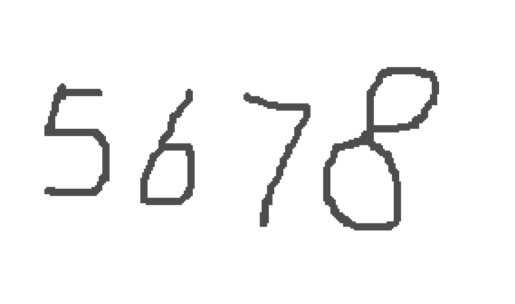

5678


In [11]:
#展示图片
import matplotlib.pyplot as plt
img = Image.open('./data/5678.png')
# 显示图像
plt.imshow(img)
plt.axis('off')  # 可选，关闭坐标轴
plt.show()

predict_digit = []

for image in digit_images:
    predict_digit.append(predict_image(image, model))
print(''.join(predict_digit))